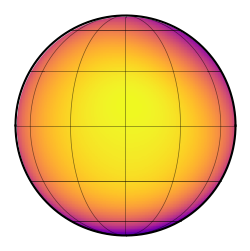

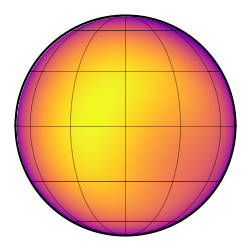

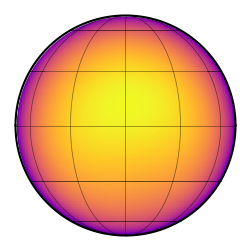

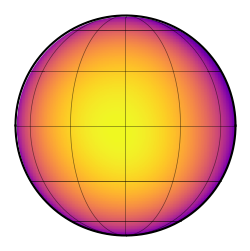

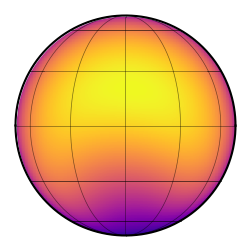

Generated 5 systems with spotted primary + uniform secondary.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import starry

import theano
theano.config.gcc__cxxflags += " -fexceptions"

# ----------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------

# Base directory for saving all system outputs
BASE_DIR = "data/simulatedataset/"  # Change this to your desired path

# Ensure the base directory exists:
if not os.path.exists(BASE_DIR):
    os.makedirs(BASE_DIR)

# Number of systems to generate
N = 5

# Random seed for reproducibility
RANDOM_SEED = 42

# Spot parameters for the primary
MIN_SPOTS = 1
MAX_SPOTS = 5
RADIUS_RANGE = [10.0, 30.0]     # uniform in this range
CONTRAST_RANGE = [0.25, 0.75]   # uniform in this range

# Primary star parameter ranges
# (You can adapt these as you wish, or fix them. Shown random as example.)
# PRIMARY_R_RANGE = [0.8, 1.2]   # in R_sun
PRIMARY_R_RANGE=[1,1]
# PRIMARY_M_RANGE = [0.8, 1.2]   # in M_sun
PRIMARY_M_RANGE=[1,1]
#PRIMARY_PROT_RANGE = [1, 50]  # rotational period in days
PRIMARY_PROT_RANGE = [30,30]    # rotational period in days


PRIMARY_U1_RANGE = [0.2, 0.6]  # limb darkening coeff 1
PRIMARY_U2_RANGE = [0.0, 0.3]  # limb darkening coeff 2
PRIMARY_INC_RANGE = [90.0, 90.0]  # inclination in degrees

# Secondary star parameter ranges
# SECONDARY_R_RANGE = [0.4, 0.8]   # in R_sun
SECONDARY_R_RANGE=[0.5,0.5]
# SECONDARY_M_RANGE = [0.5, 0.9]   # in M_sun
SECONDARY_M_RANGE=[0.75,0.75]
# SECONDARY_PORB_RANGE = [0.5, 5]    # orbital period in days
SECONDARY_PORB_RANGE = [5]
SECONDARY_PROT_RANGE = [1, 50]    # rotational period in days
SECONDARY_PROT_RANGE = [0.1, 5.0]    # rotational period in days
SECONDARY_T0_RANGE = [0.0, 0.3]      # reference time in days
SECONDARY_U1_RANGE = [0.1, 0.3]      # limb darkening coeff 1
SECONDARY_U2_RANGE = [0.0, 0.1]      # limb darkening coeff 2
# SECONDARY_INC_RANGE = [70.0, 90.0]   # inclination in degrees
SECONDARY_INC_RANGE = [90.0, 90.0]
# # Time array for light curve (can be adjusted as needed)
# t_min, t_max, N_points = -2.5, 2.5, 1000
# times = np.linspace(t_min, t_max, N_points)

# White noise std dev
NOISE_STD = 0.0005

# Spherical harmonic degrees
YDEG = 5
UDEG = 2

# Suppose we want exactly 10 transits for each system
N_TRANSITS = 10
N_POINTS = 1000  # total data points per light curve



# ----------------------------------------------------------------
# SETUP
# ----------------------------------------------------------------
np.random.seed(RANDOM_SEED)
starry.config.lazy = False
starry.config.quiet = True

# ----------------------------------------------------------------
# FUNCTION TO DRAW A RANDOM VALUE IN [low, high]
# ----------------------------------------------------------------
def uniform_range(low, high):
    return np.random.rand() * (high - low) + low

# ----------------------------------------------------------------
# MAIN LOOP
# ----------------------------------------------------------------
for i in range(N):

    # # Create an output directory for each system
    # system_dir = f"system_{i:03d}"
    # if not os.path.exists(system_dir):
    #     os.makedirs(system_dir)

    # Create an output directory for each system relative to BASE_DIR
    system_dir = os.path.join(BASE_DIR, f"system_{i:03d}")
    if not os.path.exists(system_dir):
        os.makedirs(system_dir)


    # ---------------------
    # 1) Random parameters
    # ---------------------

    # Primary
    A_r = uniform_range(*PRIMARY_R_RANGE)
    A_m = uniform_range(*PRIMARY_M_RANGE)
    A_prot = uniform_range(*PRIMARY_PROT_RANGE)
    A_inc = uniform_range(*PRIMARY_INC_RANGE)
    A_u1 = uniform_range(*PRIMARY_U1_RANGE)
    A_u2 = uniform_range(*PRIMARY_U2_RANGE)

    # We'll fix the amplitude to 1.0, but you could randomize if desired
    A_amp = 1.0

    # Secondary
    B_r = uniform_range(*SECONDARY_R_RANGE)
    B_m = uniform_range(*SECONDARY_M_RANGE)
    B_porb = uniform_range(*SECONDARY_PORB_RANGE)
    B_prot = uniform_range(*SECONDARY_PROT_RANGE)
    B_t0 = uniform_range(*SECONDARY_T0_RANGE)
    B_inc = uniform_range(*SECONDARY_INC_RANGE)

    # Define start & stop times so we see 10 orbits:
    t_start = 0.0
    t_stop = N_TRANSITS * B_porb

    # Create your time array:
    times = np.linspace(t_start, t_stop, N_POINTS)

    # We'll fix the amplitude to something smaller, e.g., 0.1
    B_amp = 0.6

    B_u1 = uniform_range(*SECONDARY_U1_RANGE)
    B_u2 = uniform_range(*SECONDARY_U2_RANGE)

    # -------------------------
    # 2) Create the primary map
    # -------------------------
    mapA = starry.Map(ydeg=YDEG, udeg=UDEG, inc=A_inc, amp=A_amp)
    # Store limb darkening in map
    mapA[1] = A_u1
    mapA[2] = A_u2

    # Now add 1-5 random spots
    n_spots = np.random.randint(MIN_SPOTS, MAX_SPOTS + 1)
    for _ in range(n_spots):
        radius = uniform_range(*RADIUS_RANGE)
        contrast = uniform_range(*CONTRAST_RANGE)
        lat = uniform_range(-90.0, 90.0)
        lon = uniform_range(0.0, 360.0)

        # Add the spot
        mapA.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # We extract the spherical harmonic coefficients from the final map
    # Note: starry.Map.y is [1 + ydeg*(ydeg+1)] in size for Y_l^m.
    # You can exclude the first term if you just want the shape coefficients
    # but typically you'd store them all.
    A_y_all = mapA.y  # includes y0

    # # Show the map (first image)
    # fig_show = mapA.show(return_fig=True)
    # fig_show.savefig(os.path.join(system_dir, "primary_map_show.png"))
    # plt.close(fig_show)

    # Display the map (this will create the figure)
    mapA.show()
    # Get the current figure
    fig_show = plt.gcf()
    # Set the title
    fig_show.suptitle("Primary star map with spots")
    # Save the figure to a file in your system directory
    fig_show.savefig(os.path.join(system_dir, "primary_map_show.png"))
    plt.close(fig_show)



    # Render the map in rectangular projection (second image)
    res = 300  # resolution in pixels (tweak as you like)
    img_rect = mapA.render(projection="rect", res=res)
    fig_rect, ax_rect = plt.subplots()
    ax_rect.imshow(img_rect, origin="upper", extent=[0, 360, -90, 90], aspect="auto")
    ax_rect.set_xlabel("Longitude [deg]")
    ax_rect.set_ylabel("Latitude [deg]")
    ax_rect.set_title("Primary star rectangular projection")
    fig_rect.savefig(os.path.join(system_dir, "primary_map_rect.png"))
    plt.close(fig_rect)

    # ----------------------------
    # 3) Create the secondary map
    #    (uniform => no spots)
    # ----------------------------
    mapB = starry.Map(ydeg=YDEG, udeg=UDEG, inc=B_inc, amp=B_amp)
    mapB[1] = B_u1
    mapB[2] = B_u2

    # For a truly uniform star, we wouldn’t add any spots.
    # The spherical harmonic coefficients remain at their defaults.

    B_y_all = mapB.y  # store all spherical harmonic coeffs (though effectively uniform)

    # -------------------------
    # 4) Build the starry System
    # -------------------------
    pri = starry.Primary(mapA, r=A_r, m=A_m, prot=A_prot)
    sec = starry.Secondary(mapB, r=B_r, m=B_m, porb=B_porb, prot=B_prot, t0=B_t0, inc=B_inc)

    sys = starry.System(pri, sec)

    # -------------------------
    # 5) Compute the light curve
    # -------------------------
    flux_true = sys.flux(times)
    flux_obs = flux_true + NOISE_STD * np.random.randn(len(times))

    # Plot the light curve
    fig_lc, ax_lc = plt.subplots(figsize=(8, 4))
    ax_lc.plot(times, flux_obs, "k.", ms=2, alpha=0.5, label="Noisy flux")
    ax_lc.plot(times, flux_true, "r-", lw=1, label="True flux")
    ax_lc.set_xlabel("time [days]")
    ax_lc.set_ylabel("normalized flux")
    ax_lc.legend()
    fig_lc.savefig(os.path.join(system_dir, "light_curve.png"))
    plt.close(fig_lc)

    # -------------------------
    # 6) Save parameters & data
    # -------------------------
    # Store them in a dictionary or just as arrays in npz
    A_dict = dict(
        ydeg=YDEG,
        udeg=UDEG,
        inc=A_inc,
        amp=A_amp,
        r=A_r,
        m=A_m,
        prot=A_prot,
        u=[A_u1, A_u2],
        y=A_y_all,
    )

    B_dict = dict(
        ydeg=YDEG,
        udeg=UDEG,
        inc=B_inc,
        amp=B_amp,
        r=B_r,
        m=B_m,
        porb=B_porb,
        prot=B_prot,
        t0=B_t0,
        u=[B_u1, B_u2],
        y=B_y_all,
    )

    np.savez(
        os.path.join(system_dir, "eb_data.npz"),
        A=A_dict,
        B=B_dict,
        t=times,
        flux_noisy=flux_obs,
        flux_true=flux_true,
        sigma=NOISE_STD,
    )

    # You now have, for each system:
    #  - A & B dicts with star parameters
    #  - The light curve data (times, fluxes)
    #  - Primary star's two images: .show() and rectangular map
    #  - A single .npz file containing all relevant info

print(f"Generated {N} systems with spotted primary + uniform secondary.")


In [5]:
import os
print(os.getcwd())


/pdo/users/pablomer/starmap/tutorials


In [6]:
print(os.path.abspath("data/simulatedataset/"))


/pdo/users/pablomer/starmap/tutorials/data/simulatedataset


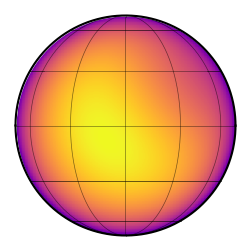

AttributeError: 'NoneType' object has no attribute 'subtitle'

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import starry
import theano

# Allow exceptions in theano compilation (required for starry)
theano.config.gcc__cxxflags += " -fexceptions"

# ----------------------------
# CONFIGURATION & OUTPUT PATH
# ----------------------------
output_dir = "exact_example_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Spherical harmonic degrees for both stars
YDEG = 5
UDEG = 2

# ----------------------------
# PRIMARY STAR PARAMETERS
# ----------------------------
primary_r = 1.0        # stellar radius [solar radii]
primary_m = 1.0        # stellar mass [solar masses]
primary_prot = 30.0    # rotational period [days]
primary_inc = 90.0     # inclination [deg]
primary_amp = 1.0      # amplitude scaling of the brightness

# Limb darkening coefficients
primary_u1 = 0.4
primary_u2 = 0.1

# Fixed single spot parameters (exactly one spot)
spot_lat = 20.0        # spot latitude in degrees
spot_lon = 30.0        # spot longitude in degrees
spot_radius = 15.0     # spot radius in degrees
spot_contrast = 0.5    # spot contrast

# Create the primary star map with fixed parameters
map_primary = starry.Map(ydeg=YDEG, udeg=UDEG, inc=primary_inc, amp=primary_amp)
# Set limb darkening coefficients
map_primary[1] = primary_u1
map_primary[2] = primary_u2
# Add the single spot
map_primary.spot(contrast=spot_contrast, radius=spot_radius, lat=spot_lat, lon=spot_lon)

# ----------------------------
# SECONDARY STAR PARAMETERS
# ----------------------------
secondary_r = 0.5       # stellar radius [solar radii]
secondary_m = 0.75      # stellar mass [solar masses]
secondary_porb = 5.0    # orbital period [days]
secondary_prot = 1.0    # rotational period [days]
secondary_t0 = 0.0      # reference time [days]
secondary_inc = 90.0    # inclination [deg]
secondary_amp = 0.6     # amplitude scaling

# Limb darkening coefficients for the secondary (uniform brightness)
secondary_u1 = 0.2
secondary_u2 = 0.05

# Create the secondary star map (uniform, without spots)
map_secondary = starry.Map(ydeg=YDEG, udeg=UDEG, inc=secondary_inc, amp=secondary_amp)
map_secondary[1] = secondary_u1
map_secondary[2] = secondary_u2

# ----------------------------
# VISUALIZATION OF MAPS
# ----------------------------

# 1) Show the primary star map (orthographic projection)
fig_primary = map_primary.show(return_fig=True)
fig_primary.subtitle("Primary Star Map with One Spot")
fig_primary.savefig(os.path.join(output_dir, "primary_star_map.png"))
plt.close(fig_primary)

# 2) Show the secondary star map (orthographic projection)
fig_secondary = map_secondary.show(return_fig=True)
fig_secondary.suptitle("Secondary Star Uniform Map")
fig_secondary.savefig(os.path.join(output_dir, "secondary_star_map.png"))
plt.close(fig_secondary)

# 4) Render a projected (rectangular) map of the primary star
resolution = 300  # pixels for rendering
img_primary_rect = map_primary.render(projection="rect", res=resolution)
fig_rect, ax_rect = plt.subplots()
ax_rect.imshow(img_primary_rect, origin="upper", extent=[0, 360, -90, 90], aspect="auto")
ax_rect.set_xlabel("Longitude [deg]")
ax_rect.set_ylabel("Latitude [deg]")
ax_rect.set_title("Primary Star Projected Map (Rectangular)")
fig_rect.savefig(os.path.join(output_dir, "primary_star_projected_map.png"))
plt.close(fig_rect)

# ----------------------------
# BUILDING THE SYSTEM & LIGHTCURVE
# ----------------------------

# Define primary and secondary stars in the starry system
primary_star = starry.Primary(map_primary, r=primary_r, m=primary_m, prot=primary_prot)
secondary_star = starry.Secondary(map_secondary, r=secondary_r, m=secondary_m,
                                    porb=secondary_porb, prot=secondary_prot,
                                    t0=secondary_t0, inc=secondary_inc)

# Create the system (primary with an orbiting secondary)
system = starry.System(primary_star, secondary_star)

# Define a time array for the light curve (here covering 10 secondary orbits)
N_POINTS = 1000
t_start = 0.0
t_stop = 10 * secondary_porb
times = np.linspace(t_start, t_stop, N_POINTS)

# Compute the theoretical lightcurve (flux)
flux_true = system.flux(times)
# Add a bit of noise (optional) to simulate observations
noise_std = 0.001
flux_noisy = flux_true + noise_std * np.random.randn(len(times))

# 3) Plot the lightcurve
fig_lc, ax_lc = plt.subplots(figsize=(8, 4))
ax_lc.plot(times, flux_noisy, "k.", ms=2, alpha=0.5, label="Noisy Flux")
ax_lc.plot(times, flux_true, "r-", lw=1, label="True Flux")
ax_lc.set_xlabel("Time [days]")
ax_lc.set_ylabel("Normalized Flux")
ax_lc.legend()
ax_lc.set_title("Simulated Light Curve")
# fig_lc.savefig(os.path.join(output_dir, "lightcurve.png"))
# plt.close(fig_lc)

print("Visualizations saved in the directory:", output_dir)
